In [1]:
import torch
import xutorch

In [2]:
args = {
    'kernel_func': 'linear',
    'c': 0.01,
    'lr': 0.01,
    'num_epochs': 1000,
    'batch_size': 12,
    'early_stop': 100,
    'save_path': 'weights/hw2_model.pth'
}

In [3]:
train_loader, train_dataset = xutorch.dataset.prep_dataloader(
    dataset_name='BreastCancer',
    download=True,
    train=True,
    batch_size=args['batch_size'],
    test_ratio=0.25,
    transform=True
)
val_loader, val_dataset = xutorch.dataset.prep_dataloader(
    dataset_name='BreastCancer',
    download=True,
    train=False,
    batch_size=args['batch_size'],
    test_ratio=0.25,
    transform=True
)

Finished reading the train set of BreastCancer Dataset (444 samples found, each dim = 30)
Finished reading the val set of BreastCancer Dataset (125 samples found, each dim = 30)


In [4]:
xutorch.misc.set_seeds(42)

device = xutorch.misc.get_device()

model = xutorch.model.EmulatedSVM(kernel_func=args['kernel_func'], input_dim=train_dataset.dim, output_dim=1).to(device)

# 创建一个Hinge损失函数
criterion = xutorch.loss.Hinge(args['c'])

optimizer = xutorch.optim.SimpleSGD(model.parameters(), lr=args['lr'])

In [5]:
loss_record = {
    'train': [], 
    'val': []
}

best_val_acc = 0.0
best_val_acc_epoch = 0.0

early_stop_cnt = 0

for epoch in range(args['num_epochs']):
    train_acc = 0.0
    train_loss = 0.0

    model.train()
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        train_pred = torch.sign(outputs)

        weight = model.fc.weight.squeeze()
        loss = criterion(outputs, labels, weight)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += loss.item()
    loss_record['train'].append(train_loss / len(train_dataset))

    val_acc = 0.0
    val_loss = 0.0

    model.eval()
    for batch_idx, (inputs, labels) in enumerate(val_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            val_pred = torch.sign(outputs)

            weight = model.fc.weight.squeeze()
            loss = criterion(outputs, labels, weight)
        
        val_acc += (val_pred.cpu() == labels.cpu()).sum().item()
        val_loss += loss.item()
    loss_record['val'].append(val_loss / len(val_dataset))

    if epoch == 0 or val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_acc_epoch = epoch
        print(f'Saving model (epoch = {epoch + 1 : 4d}, acc = {best_val_acc / len(val_dataset) : .4f})')
        torch.save(model.state_dict(), args['save_path'])
        early_stop_cnt = 0
    else:
        early_stop_cnt += 1
    
    if early_stop_cnt > args['early_stop']:
        print('**EARLY STOP**')
        break

    if epoch % 10 == 9:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
            epoch + 1, args['num_epochs'], 
            train_acc / len(train_dataset), train_loss / len(train_dataset), 
            val_acc / len(val_dataset), val_loss / len(val_dataset)))

Saving model (epoch =    1, acc =  0.9040)
Saving model (epoch =    2, acc =  0.9360)
Saving model (epoch =    3, acc =  0.9440)
Saving model (epoch =    4, acc =  0.9600)
Saving model (epoch =    6, acc =  0.9680)
[010/1000] Train Acc: 0.977477 Loss: 0.007894 | Val Acc: 0.968000 loss: 0.010868
[020/1000] Train Acc: 0.981982 Loss: 0.006601 | Val Acc: 0.968000 loss: 0.009654
[030/1000] Train Acc: 0.981982 Loss: 0.006119 | Val Acc: 0.968000 loss: 0.009449
[040/1000] Train Acc: 0.984234 Loss: 0.005829 | Val Acc: 0.968000 loss: 0.009279
[050/1000] Train Acc: 0.981982 Loss: 0.005613 | Val Acc: 0.968000 loss: 0.009149
[060/1000] Train Acc: 0.981982 Loss: 0.005473 | Val Acc: 0.968000 loss: 0.008954
Saving model (epoch =   64, acc =  0.9760)
[070/1000] Train Acc: 0.981982 Loss: 0.005379 | Val Acc: 0.968000 loss: 0.008810
[080/1000] Train Acc: 0.981982 Loss: 0.005323 | Val Acc: 0.968000 loss: 0.008780
[090/1000] Train Acc: 0.979730 Loss: 0.005286 | Val Acc: 0.976000 loss: 0.008758
[100/1000] Tr

In [6]:
params = model.state_dict()

for name, param in params.items():
    print(name, param)

# 对乳腺癌影响最显著的两个feature
feature_names = ["Mean_Radius", "Mean_Texture", "Mean_Perimeter", "Mean_Area", "Mean_Smoothness", "Mean_Compactness", "Mean_Concavity", "Mean_Concave_Points", "Mean_Symmetry", "Mean_Fractal_Dimension", "SE_Radius", "SE_Texture", "SE_Perimeter", "SE_Area", "SE_Smoothness", "SE_Compactness", "SE_Concavity", "SE_Concave_Points", "SE_Symmetry", "SE_Fractal_Dimension", "Worst_Radius", "Worst_Texture", "Worst_Perimeter", "Worst_Area", "Worst_Smoothness", "Worst_Compactness", "Worst_Concavity", "Worst_Concave_Points", "Worst_Symmetry", "Worst_Fractal_Dimension"]
feature_names[torch.max(model.fc.weight, 1)[1].item()], feature_names[torch.min(model.fc.weight, 1)[1].item()]

fc.weight tensor([[ 0.2650,  0.2481,  0.1537,  0.3058,  0.1708, -0.1461,  0.2963,  0.3841,
         -0.0040, -0.3619,  0.5232, -0.2604,  0.3518,  0.3636,  0.1659, -0.3340,
          0.0677,  0.0669, -0.1391, -0.1785,  0.3508,  0.5606,  0.3077,  0.4505,
          0.4458, -0.0076,  0.3460,  0.3579,  0.4218,  0.1251]],
       device='cuda:0')
fc.bias tensor([-0.1809], device='cuda:0')


('Worst_Texture', 'Mean_Fractal_Dimension')

In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

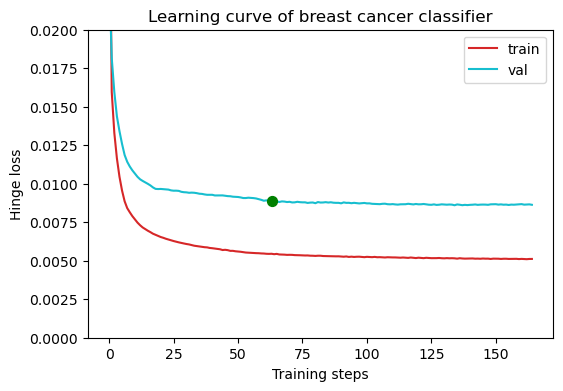

In [8]:
xutorch.plot.plot_learning_curve(loss_record, title='breast cancer classifier', loss_name='Hinge', bottom=0.0, top=0.02, min_loss_x=best_val_acc_epoch, min_loss_y=loss_record['val'][best_val_acc_epoch])